## Predict pH optimum and range directly
- Previous I used the difference in activity as the loss funciton
- What if we just fit a normal distribution to each protein/experiment, and try to predict the mean (optimum) and standard deviation (range) directly?

2023-10-19 update:
- Here we will also train with one-hot embeddings of the other enzyme information (e.g., enzyme type, enzyme type-sub)

In [1]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
os.chdir("../../../")
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering'

In [5]:
torch.hub.set_dir('/scratch/jlaw/torch')
model_name = "esm2_t33_650M_UR50D"
# model_name = "esm2_t36_3B_UR50D"
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)

Using cache found in /scratch/jlaw/torch/facebookresearch_esm_main


### Build/get embeddings

In [6]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file, index_col=0)
    sequences.set_index("uniprot_id", inplace=True)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [7]:
# inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/")
inputs_dir = "inputs/brenda"

embeddings, df_seq = read_embeddings(Path(inputs_dir, "uniprot/20230926_embeddings_esm2_t33_650M_UR50D.npz"),
                                     Path(inputs_dir, "uniprot/20230926_embeddings_seqs.csv"))

# embeddings2, df_seq2 = read_embeddings(Path(inputs_dir, "uniprot/embeddings/20230504_embeddings_esm2_t33_650M_UR50D.npz"),
#                                           Path(inputs_dir, "uniprot/embeddings/20230504_embeddings_seqs.csv"))

# embeddings = np.vstack([embeddings, embeddings2])
print(embeddings.shape)
# df_seq = pd.concat([df_seq, df_seq2], ignore_index=True).reset_index(drop=True)

len(embeddings) = 12913 read from inputs/brenda/uniprot/20230926_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 12913 read from inputs/brenda/uniprot/20230926_embeddings_seqs.csv
(12913, 1280)


In [8]:
df_seq.head(2)

,sequence
uniprot_id,
B2KJ46,MGEIESYCNKELGPLPTKAPTLSKNVLDLFSLKGKVASVTGSSGGI...
Q4J702,MDIDRLFSVKGMNAVVLGASSGIGKAIAEMFSEMGGKVVLSDIDEE...


In [27]:
# This file has all the ph range data + optimum ph data
data_file = Path("inputs/ph_merged/20230927_ph_curves.csv")
data_fits = pd.read_csv(data_file)
print(len(data_fits), data_fits.uniprot_id.nunique())
data_fits.head(2)

13405 12994


,uniprot_id,reaction_type,fit_mean,fit_std,num_act,max_min_diff,enzyme_type,enzyme_type_sub,acceptor
0,05650,NaN,8.4,NaN,1,NaN,Lyases,Carbon-carbon,NaN
1,5650,NaN,8.4,NaN,1,NaN,Oxidoreductases,aldehyde or oxo group of donors,iron-sulfur protein


In [28]:
data_fits.fit_mean.describe()

count    13405.000000
mean         7.217512
std          1.380924
min          1.000000
25%          6.500000
50%          7.450000
75%          8.000000
max         12.500000
Name: fit_mean, dtype: float64

In [29]:
data_fits.fit_std.describe()

count    2765.000000
mean        1.330199
std         0.703292
min         0.119048
25%         0.849322
50%         1.158647
75%         1.596539
max         4.000000
Name: fit_std, dtype: float64

In [30]:
data_fits = data_fits.drop(columns=['num_act', 'max_min_diff'])

In [31]:
data_fits = data_fits.replace("?", np.nan)

In [32]:
data_fits.reaction_type.value_counts()

oxidation    634
reduction    473
Name: reaction_type, dtype: int64

In [33]:
len(data_fits.dropna(subset="fit_std"))

2765

In [34]:
# now limit the proteins to those with an embedding and relevant data
data_fits = data_fits[data_fits.uniprot_id.isin(df_seq.index)]
print(data_fits.uniprot_id.nunique(), len(data_fits))
data_fits.dropna(subset=['fit_mean'], how="any", inplace=True)
print(data_fits.uniprot_id.nunique(), len(data_fits))

12663 13064
12663 13064


In [35]:
uniprot_to_seq = dict(zip(df_seq.index, df_seq.sequence))
seq_to_uniprot = dict(zip(df_seq.sequence, df_seq.index))

In [36]:
data_fits['sequence'] = data_fits.uniprot_id.apply(lambda x: uniprot_to_seq[x])

In [37]:
# # try using a one-hot encoding of just oxidation and reduction
# data_fits['oxidation'] = data_fits.reaction_type.apply(lambda x: x == 'oxidation').astype(int)
# data_fits['reduction'] = data_fits.reaction_type.apply(lambda x: x == 'reduction').astype(int)
# data_fits[data_fits.reaction_type == 'reduction'].head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,enzyme_type,enzyme_type_sub,acceptor,sequence,oxidation,reduction
5,A0A023RBJ1,reduction,5.5,NaN,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,MADKLPEEEHPKPAFGWAARDQSGLLSPFKFSRRATGEKDVAFKVL...,0,1
17,A0A059TC02,reduction,6.0,NaN,Oxidoreductases,aldehyde or oxo group of donors,NAD+ or NADP+,MRSVSGQVVCVTGAGGFIASWLVKILLEKGYTVRGTVRNPDDPKNG...,0,1


In [46]:
df_seq_uniq = data_fits['sequence'].drop_duplicates()
# print(len(df_seq_uniq), len(df_seq))
# df_seq_uniq = df_seq_uniq[df_seq_uniq.uniprot_id.isin(data_act_merged.uniprot_id.unique())]
print(len(df_seq_uniq), data_fits.uniprot_id.nunique())

12501 12663


In [39]:
df_seq_uniq.head(2)

2    MRTYRLTYSDIRGRAELARLVFVAAGESFEDRRVSREEWAELKKET...
3    MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...
Name: sequence, dtype: object

### Split into train/test

option 1: random split

In [105]:
# just take a random split for now
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_seq_uniq.values, test_size=0.1)
train = set(train)
test = set(test)
print(len(train), len(test))

11250 1251


option 2: mantain test split from ph_range data only

In [47]:
# optionally run this instead to keep the same train and test set as previous run
split_file = "results/20230914_ph_range/df_split.csv"
df = pd.read_csv(split_file)
test = df[df.set == "test"]
print(len(test))
test.head(2)
# train = df_seq_uniq[~df_seq_uniq.uniprot_id.isin(df_test.uniprot_id)].set_index('uniprot_id')
# test = df_seq_uniq[df_seq_uniq.uniprot_id.isin(df_test.uniprot_id)].set_index('uniprot_id')
# print(len(train), len(test))

250


,uniprot_id,sequence,set
2245,P9WQB0,MRVGIPTETKNNEFRVAITPAGVAELTRRGHEVLIQAGAGEGSAIT...,test
2246,A3LY17,MLFSYFPALVALCSTVSALGGLQNIVFKNSKDDLQLAAHKKSATLF...,test


In [106]:
def train_test_split(seq):
    if isinstance(test, set):
        if seq in test:
            return "test"
    else:
        if seq in test.sequence.values:
            return "test"
    return "train"

data_fits['split'] = data_fits.sequence.apply(train_test_split)
df_split = data_fits[["uniprot_id", "sequence", "split"]].drop_duplicates()
df_split.head(2)

,uniprot_id,sequence,split
2,A0A023I760,MRTYRLTYSDIRGRAELARLVFVAAGESFEDRRVSREEWAELKKET...,train
3,A0A023I7E1,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,train


### Choose the columns to use as features

In [20]:
from sklearn.preprocessing import OneHotEncoder

In [104]:
# reaction type should be relabeled "redox_type"
# categ_cols = ['reaction_type']
# categ_cols = ['reaction_type', 'enzyme_type']
# categ_cols = ['reaction_type', 'enzyme_type', 'enzyme_type_sub']
categ_cols = ['reaction_type', 'enzyme_type', 'enzyme_type_sub', 'acceptor']

In [107]:
def get_one_hot_encoder(data_fits, categ_cols):
    enc = OneHotEncoder(drop=[np.nan] * len(categ_cols))
    enc.fit(data_fits[categ_cols])
    return enc

enc = get_one_hot_encoder(data_fits, categ_cols)

### Predict a normal distribution for each sequence
The loss will be the MAE of the points compared to the curve

In [108]:
df_split.split.value_counts()

train    11390
test      1273
Name: split, dtype: int64

In [49]:
df_split.split.value_counts()

train    12416
test       247
Name: split, dtype: int64

In [50]:
# seq_idx = {seq: idx for idx, seq in df_seq.sequence.items
seq_idx = dict(zip(df_seq.sequence, df_seq.reset_index().index))
# print(list(seq_idx.items())[:2])

In [109]:
df_train = data_fits[data_fits.split == "train"]
df_test = data_fits[data_fits.split == "test"]
df_train.head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,enzyme_type,enzyme_type_sub,acceptor,sequence,split
2,A0A023I760,NaN,8.0,NaN,Transferases,"alkyl or aryl groups, other than methyl groups",NaN,MRTYRLTYSDIRGRAELARLVFVAAGESFEDRRVSREEWAELKKET...,train
3,A0A023I7E1,NaN,5.5,NaN,Hydrolases,Glycosylases,NaN,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,train


In [111]:
def get_embeddings_and_features(df, embeddings, seq_idx, enc, categ_cols):
    # some of the sequences are repeated, so get their embeddings by index
    X_split = np.asarray([embeddings[seq_idx[seq]] for seq in df.sequence.values])
    encoded_features = enc.transform(df[categ_cols]).toarray()
    X_split = np.hstack([X_split, encoded_features])
    y_split = df[['fit_mean', 'fit_std']].values
    return X_split, y_split

X_train, y_train = get_embeddings_and_features(df_train, embeddings, seq_idx, enc, categ_cols)
X_test, y_test = get_embeddings_and_features(df_test, embeddings, seq_idx, enc, categ_cols)
print(X_train.shape, f"{len(df_train) / (len(df_train) + len(df_test)):0.2f}")
print(X_test.shape, f"{len(df_test) / (len(df_train) + len(df_test)):0.2f}")

(11743, 1363) 0.90
(1321, 1363) 0.10


In [48]:
y_train[:,0].max(), y_train[:,0].min()

(12.5, 1.0)

### Build neural net on sequence embeddings

In [58]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [59]:
class neural_network_fits(pl.LightningModule):
    def __init__(self, initial_layer_size=1280, lr=1e-3):
        """ Given an input esm2 sequence embedding, 
        predicts the mean and sigma (standard deviation) parameters e.g., for pH activity curves.
        """
        super(neural_network_fits, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.LeakyReLU(),            
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),
        )
        self.lr = lr
        # l1 loss reduction
        self.reduction = "mean"

    def forward(self, x):
        # predict the mean and std deviation
        logits = self.linear_relu_stack(x)
        # return logits
        # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]

        # take the sigmoid of the pH mean logits, then multiply by 13 to get in the range 0-13
        y_pred_mean = torch.sigmoid(logits[:,0])
        y_pred_mean = torch.multiply(y_pred_mean, 13)
        # limit the standard deviation to between 0 and 4.25
        y_pred_sigma = torch.sigmoid(logits[:,1])
        y_pred_sigma = torch.multiply(y_pred_sigma, 4.25)
        return y_pred_mean, y_pred_sigma
#         return dist, y_pred_mean, y_pred_sigma

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_opt, y_std = y[:,0], y[:,1]
        
        # logits = self(x)
        # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
        y_pred_mean, y_pred_sigma = self(x)

        # use mse_loss or l1_loss (mae) on both the ph opt
        loss = nn.functional.l1_loss(y_pred_mean, y_opt, reduction=self.reduction)
        # and the ph standard deviation. Only use rows that are not nan
        loss += nn.functional.l1_loss(y_pred_sigma[~torch.isnan(y_std)], 
                                      y_std[~torch.isnan(y_std)],
                                      reduction=self.reduction)
        self.log('train_loss', loss)
        return loss
    
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_ph, y_act = y[:,0], y[:,1]
        
#         y_pred = self(x)
#         y_pred_mean, y_pred_sigma = y_pred[:,0], y[:,1]
#         y_pred_act = self.get_gaus_pred(y_ph, y_pred_mean, y_pred_sigma)

#         loss = nn.functional.l1_loss(y_pred_act, y_act)
#         self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [60]:
def fit_model(X_train, y_train, X_valid, epochs=20, lr=1e-3):
    pl.seed_everything(42)
    model = neural_network_fits(initial_layer_size=X_train.shape[1], 
                                lr=lr,
                               )
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=epochs,
        check_val_every_n_epoch=5)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model, trainer

In [61]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
# For debugging, just look at 10 rows
# X_train_2 = X_train[:10,:]
# y_train_2 = y_train[:10,:]
# X_test_2 = X_test[:10,:]
# head_model_2 = fit_model(X_train_2, y_train_2, X_test_2, epochs=20)

In [62]:
def eval_model(head_model, X_test, y_test, to_print=""):
    # logits = head_model(torch.Tensor(X_test)).detach().numpy()
    # y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]
    y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
    y_pred_mean, y_pred_sigma = y_pred_mean.detach().numpy(), y_pred_sigma.detach().numpy()
    y_opt, y_std = y_test[:,0], y_test[:,1]
    df_err = pd.DataFrame({"pH opt": y_opt, "pH std": y_std, "ML pH opt": y_pred_mean, "ML pH std": y_pred_sigma})
    y_pred_sigma = y_pred_sigma[~np.isnan(y_std)]
    y_std = y_std[~np.isnan(y_std)]

    # now calculate the overall MAE
    # df_err = []
    for y_true, y_pred, name in zip([y_opt, y_std], [y_pred_mean, y_pred_sigma], ["pH opt", "pH std"]):
        rho, _ = spearmanr(y_pred, y_true)  # spearman
        mse = mean_squared_error(y_pred, y_true)  # Mean Squared Error
        mae = np.mean(np.abs(y_pred - y_true))  # Mean Absolute Error
        print(f"{to_print}{name}, {mae:0.2f}, {mse:0.2f}, {rho:0.2f}")
        
    return y_pred_mean, y_pred_sigma, df_err

In [66]:
X_test.shape

(263, 1288)

In [114]:
epochs = 50
lr = 1e-4
categ_col_sets = [
    ['reaction_type'],
    ['reaction_type', 'enzyme_type'],
    ['reaction_type', 'enzyme_type', 'enzyme_type_sub'],
    ['reaction_type', 'enzyme_type', 'enzyme_type_sub', 'acceptor'],
]
for categ_cols in categ_col_sets:
    enc = get_one_hot_encoder(data_fits, categ_cols)
    X_train, y_train = get_embeddings_and_features(df_train, embeddings, seq_idx, enc, categ_cols)
    X_test, y_test = get_embeddings_and_features(df_test, embeddings, seq_idx, enc, categ_cols)
# for batch_size in 
    head_model, trainer = fit_model(X_train, y_train, X_test, epochs=epochs, lr=lr)
    eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, {' + '.join(categ_cols)}, ")
    eval_model(head_model, X_train, y_train, f"train, {epochs}, {lr}, {' + '.join(categ_cols)}, ")

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 920 K 
-------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.682     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


test, 50, 0.0001, reaction_type, pH opt, 0.73, 0.99, 0.64
test, 50, 0.0001, reaction_type, pH std, 0.58, 0.66, 0.18
train, 50, 0.0001, reaction_type, pH opt, 0.32, 0.28, 0.93
train, 50, 0.0001, reaction_type, pH std, 0.17, 0.09, 0.91


Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 924 K 
-------------------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.697     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


test, 50, 0.0001, reaction_type + enzyme_type, pH opt, 0.74, 1.03, 0.62
test, 50, 0.0001, reaction_type + enzyme_type, pH std, 0.57, 0.66, 0.25
train, 50, 0.0001, reaction_type + enzyme_type, pH opt, 0.33, 0.27, 0.93
train, 50, 0.0001, reaction_type + enzyme_type, pH std, 0.18, 0.09, 0.91


Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 956 K 
-------------------------------------------------
956 K     Trainable params
0         Non-trainable params
956 K     Total params
3.828     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


test, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub, pH opt, 0.74, 0.99, 0.64
test, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub, pH std, 0.56, 0.63, 0.26
train, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub, pH opt, 0.31, 0.26, 0.93
train, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub, pH std, 0.15, 0.08, 0.92


Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 962 K 
-------------------------------------------------
962 K     Trainable params
0         Non-trainable params
962 K     Total params
3.848     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


test, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub + acceptor, pH opt, 0.72, 0.97, 0.66
test, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub + acceptor, pH std, 0.54, 0.59, 0.32
train, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub + acceptor, pH opt, 0.31, 0.25, 0.94
train, 50, 0.0001, reaction_type + enzyme_type + enzyme_type_sub + acceptor, pH std, 0.15, 0.08, 0.93


In [115]:
for epochs in [50]:
    for lr in [1e-3, 1e-4]:
    # for lr in [1e-4]:
        # for batch_size in 
        head_model, trainer = fit_model(X_train, y_train, X_test, epochs=epochs, lr=lr)
        eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")
        eval_model(head_model, X_train, y_train, f"train, {epochs}, {lr}, ")

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 962 K 
-------------------------------------------------
962 K     Trainable params
0         Non-trainable params
962 K     Total params
3.848     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

Exception in thread Thread-17:
Traceback (most recent call last):
  File "/home/jlaw/.conda/envs/tm/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/tensorboard/summary/writer/event_file_writer.py", line 244, in run
    self._run()
  File "/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/tensorboard/summary/writer/event_file_writer.py", line 275, in _run
    self._record_writer.write(data)
  File "/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/tensorboard/summary/writer/record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 773, in write
    self.fs.append(self.filename, file_content, self.binary_mode)
  File "/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 167, i

OSError: [Errno 122] Disk quota exceeded

In [118]:
y_pred_mean, y_pred_sigma, df_err = eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")

test, 50, 0.001, pH opt, 0.72, 0.97, 0.66
test, 50, 0.001, pH std, 0.54, 0.59, 0.32


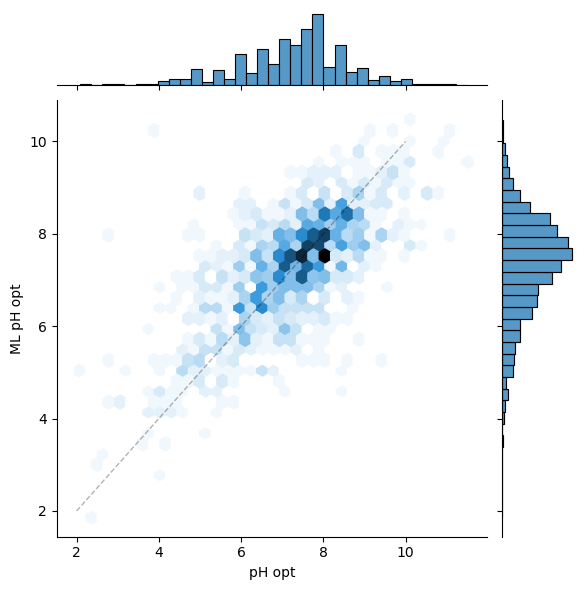

In [119]:
g = sns.jointplot(df_err, x="pH opt", y="ML pH opt", 
              # alpha=0.3, s=5, linewidth=0, 
                  kind="hex"
             )
g.ax_joint.plot([2,10], [2,10], ls='--', alpha=0.3, color="black", linewidth=1)

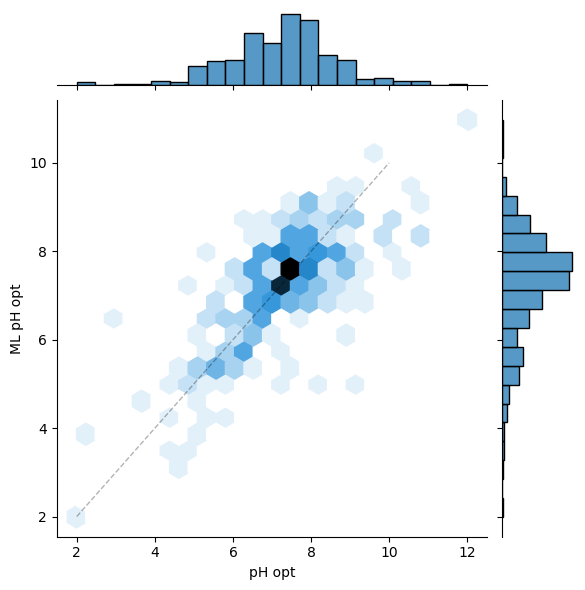

In [57]:
g = sns.jointplot(df_err, x="pH opt", y="ML pH opt", 
              # alpha=0.3, s=5, linewidth=0, 
                  kind="hex"
             )
g.ax_joint.plot([2,10], [2,10], ls='--', alpha=0.3, color="black", linewidth=1)

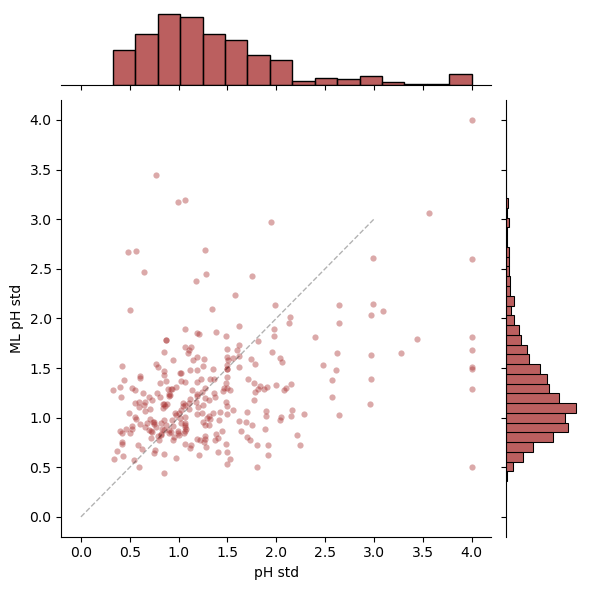

In [120]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              alpha=0.4, s=20, linewidth=0, 
                  # kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.3, color="black", linewidth=1)

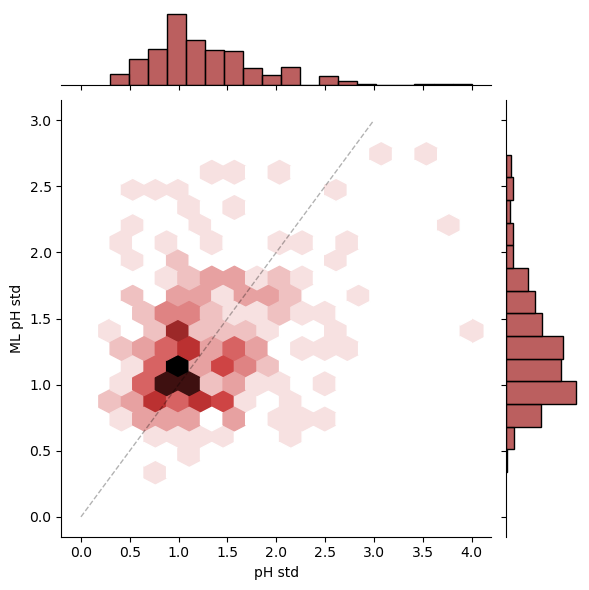

In [147]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              # alpha=0.4, s=20, linewidth=0, 
                  kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.3, color="black", linewidth=1)

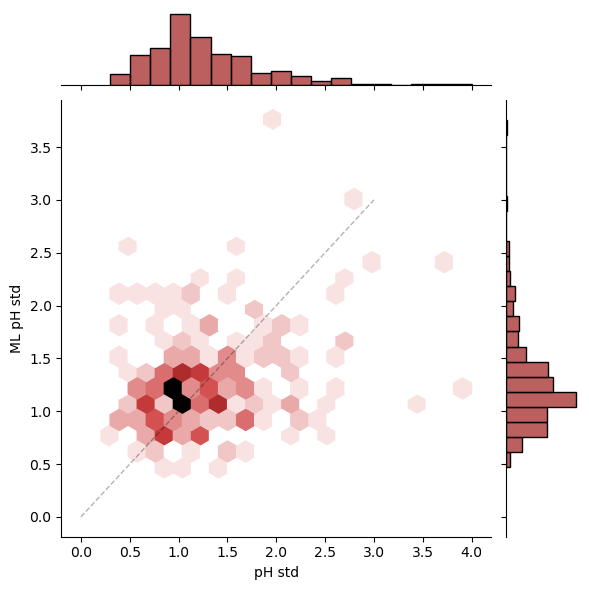

In [58]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              # alpha=0.4, s=20, linewidth=0, 
                  kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.3, color="black", linewidth=1)

Text(0.5, 1.0, 'pH ')

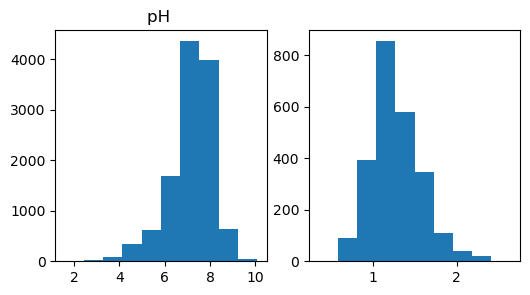

In [109]:
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(6,3))
ax.hist(y_pred_mean)
ax2.hist(y_pred_sigma)
ax.set_title("pH opt")
ax.set_title("pH ")

Text(0.5, 1.0, 'sigma_penalty: 0.1')

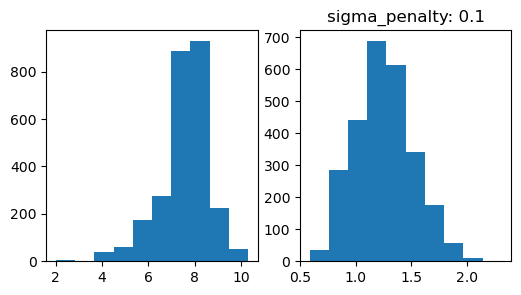

In [ ]:
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(6,3))
ax.hist(y_pred_mean)
ax2.hist(y_pred_sigma)
ax.set_title("pH opt")
ax.set_title("pH ")

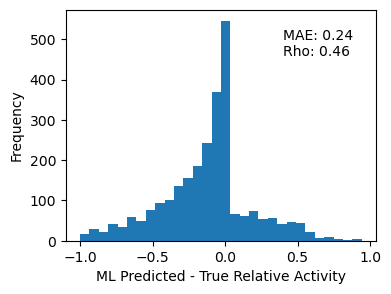

In [40]:
f, ax = plt.subplots(figsize=(4,3))
df = pd.DataFrame({'y_pred': y_pred_act, 'y_test': y_test_act})

df['y_err'] = (df['y_pred'] - df['y_test'])
df['y_err'].plot.hist(bins=30)

ax.set_xlabel("ML Predicted - True Relative Activity")
rho, _ = spearmanr(y_pred_act, y_test_act)  # spearman
mse = mean_squared_error(y_pred_act, y_test_act)  # Mean Squared Error
mae = np.mean(np.abs(y_pred_act - y_test_act))  # Mean Absolute Error
ax.text(0.7, 0.8, f"MAE: {mae:0.2f} \nRho: {rho:0.2f}",
        transform=ax.transAxes)

out_file = Path("results/20230926_ph_range/pred_err.pdf")
# out_dir = 
out_file.parent.mkdir(exist_ok=True)
plt.savefig(out_file, bbox_inches='tight')

Use the ph_range test set to see if the extra ph_opt data is helping

### Show plots for individual prots

In [67]:
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [69]:
# define the gaussian function
def gaus(x,c,x_mean,sigma):
    return c*np.exp(-(x-x_mean)**2/(2*sigma**2))

In [62]:
def get_ez_type(row):
    if row.oxidation == 1:
        return 'oxidation'
    elif row.reduction == 1:
        return 'reduction'

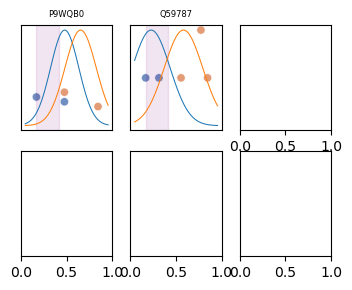

In [71]:
def plot_indv_prot_curves(df_test, y_pred_mean, y_pred_sigma, nrows=8, ncols=4):
    # get the predicted activity over all ph values
    all_ph_vals = np.arange(1, 13.5, 0.1)

    f, axes = plt.subplots(ncols=ncols, nrows=nrows, 
                           figsize=(nrows*2,ncols), 
                           sharey=True, sharex=False)
    axes_list = [ax for ax_row in axes for ax in ax_row]
    # cols = ["uniprot_id", "enzyme_type", "enzyme_type_sub", "acceptor"]
    i = -1
    df_redox = df_test[(df_test.oxidation == 1) |
                       (df_test.reduction == 1)]
    for (uniprot_id, df_u) in df_redox.groupby("uniprot_id"):
        df_u['enzyme_type'] = df_u.apply(get_ez_type, axis=1)
        df_u = df_u[df_u.enzyme_type.isin(["oxidation", "reduction"])]
        if len(df_u) <= 1:
            continue
        e_types = df_u.enzyme_type.unique()
        if 'oxidation' not in e_types or 'reduction' not in e_types:
            continue
        i += 1
        df_pred_act_u = []
        for (e_type, df_cat) in df_u.groupby('enzyme_type'):
            pred_mean_u = y_pred_mean[df_cat.index[0]].detach().numpy()
            pred_sigma_u = y_pred_sigma[df_cat.index[0]].detach().numpy()
            # print(uniprot_id, e_type, pred_mean_u, pred_sigma_u)
            pred_act = gaus(all_ph_vals, 1, pred_mean_u, pred_sigma_u)
            # limit the predicted activity to min_ph -1 and max_ph +1
            df_pred_act_u_cat = pd.DataFrame({'ph': all_ph_vals, 'activity': pred_act})
            df_pred_act_u_cat['enzyme_type'] = e_type
            ph_min = min(df_u.ph.min() - 1, 5.5)
            ph_max = max(df_u.ph.max() + 1, 8.5)
            df_pred_act_u_cat = df_pred_act_u_cat[(df_pred_act_u_cat.ph >= ph_min) & 
                                                  (df_pred_act_u_cat.ph <= ph_max)]
            df_pred_act_u += [df_pred_act_u_cat]
            # print(e_type, df_pred_act_u_cat[['ph', 'activity']].max())
        df_pred_act_u = pd.concat(df_pred_act_u)

        if i >= len(axes_list):
            break
        ax = axes_list[i]
        ax.set_title(uniprot_id, fontsize=6)
        sns.lineplot(x='ph', y='activity', data=df_pred_act_u, ax=ax,
                     # palette='deep', 
                     hue='enzyme_type', hue_order=['reduction', 'oxidation'],
                     size=1, 
                     legend=None)
        sns.scatterplot(x='ph', y='activity', data=df_u, ax=ax,
                        hue='enzyme_type', hue_order=['reduction', 'oxidation'],
                        palette='deep',
                        alpha=0.8,
                        legend=None
                       )
        ax.set_ylabel("")
        ax.set_xlabel("")
        # hide ax labels
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        # hide ax ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # add a vertical bar at ph=6--8
        ax.axvspan(6, 8, alpha=0.1, color='purple')
        # ax.set_xlabel
        # L = ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

    plt.show()
    plt.close()
    
plot_indv_prot_curves(df_test, y_pred_mean, y_pred_sigma,
                      nrows=2, ncols=3)

In [121]:
out_dir = Path("results/20231026_ph_opt_and_range")

In [122]:
# if __name__ == "__main__":
out_file = out_dir / f"20231011_ph_range_{model_name}.pt"
print(out_file)
torch.save(head_model, out_file)

results/20231026_ph_opt_and_range/20231011_ph_range_esm2_t33_650M_UR50D.pt


## Evaluate E. coli

In [61]:
data_act_merged.head(2)

NameError: name 'data_act_merged' is not defined

In [74]:
uniprot_seq_info_file = Path("inputs/ph_merged/idmapping_2023_10_19.tsv.gz")
seq_info = pd.read_table(uniprot_seq_info_file)
seq_info = seq_info.rename(columns={"From": "uniprot_id"})
print(len(seq_info))
seq_info = seq_info.dropna(subset="Organism")
print(len(seq_info))
seq_info.head(2)

12926
12896


,uniprot_id,Entry,Reviewed,Protein names,Gene Names,Organism,Organism (ID),Length,pH dependence,Kinetics,...,Temperature dependence,EC number,Catalytic activity,Cofactor,Activity regulation,Binding site,Active site,Site,Pathway,Absorption
0,A0A023I760,A0A023I760,unreviewed,Sigma class glutathione S-transferase,NaN,Hyriopsis cumingii (Triangle sail mussel) (Uni...,165450.0,203.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A023I7E1,A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,4839.0,796.0,BIOPHYSICOCHEMICAL PROPERTIES: pH dependence:...,NaN,...,BIOPHYSICOCHEMICAL PROPERTIES: Temperature de...,3.2.1.39,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,NaN,ACTIVITY REGULATION: Tris binds the active sit...,"BINDING 504; /ligand=""(1,3-beta-D-glucosyl)n"";...","ACT_SITE 500; /evidence=""ECO:0000255|PROSITE-P...",NaN,NaN,NaN


In [71]:
seq_info.Organism.value_counts()

Homo sapiens (Human)                                                                      713
Arabidopsis thaliana (Mouse-ear cress)                                                    514
Escherichia coli (strain K12)                                                             472
Rattus norvegicus (Rat)                                                                   385
Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast)                     329
                                                                                         ... 
Cryptomeria japonica (Japanese cedar) (Cupressus japonica)                                  1
Vargula hilgendorfii (Sea firefly) (Cypridina hilgendorfii)                                 1
Thermoanaerobacter thermohydrosulfuricus (Clostridium thermohydrosulfuricum)                1
Leishmania chagasi                                                                          1
Gaeumannomyces graminis (Turf grass take-all root rot fungus

In [77]:
ecoli_rows = seq_info[seq_info.Organism.apply(lambda x: "Escherichia coli" in x)]
print(len(ecoli_rows))

545


In [91]:
ecoli_prots = set(ecoli_rows.uniprot_id.values)
len(ecoli_prots)

545

In [73]:
data_fits.head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,enzyme_type,enzyme_type_sub,acceptor,sequence,oxidation,reduction,split
2,A0A023I760,NaN,8.0,NaN,Transferases,"alkyl or aryl groups, other than methyl groups",NaN,MRTYRLTYSDIRGRAELARLVFVAAGESFEDRRVSREEWAELKKET...,0,0,train
3,A0A023I7E1,NaN,5.5,NaN,Hydrolases,Glycosylases,NaN,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,0,0,train


In [94]:
def ecoli_holdout(u_id):
    if u_id in ecoli_rows.uniprot_id:
        return "test"
    else:
        return "train"
data_fits["split"] = "train"
data_fits.loc[data_fits.uniprot_id.isin(ecoli_prots), "split"] = "test"
data_fits.split.value_counts()

train    12506
test       558
Name: split, dtype: int64

In [95]:
df_train = data_fits[data_fits.split == "train"]
df_test = data_fits[data_fits.split == "test"]
df_train.head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,enzyme_type,enzyme_type_sub,acceptor,sequence,oxidation,reduction,split
2,A0A023I760,NaN,8.0,NaN,Transferases,"alkyl or aryl groups, other than methyl groups",NaN,MRTYRLTYSDIRGRAELARLVFVAAGESFEDRRVSREEWAELKKET...,0,0,train
3,A0A023I7E1,NaN,5.5,NaN,Hydrolases,Glycosylases,NaN,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,0,0,train


In [81]:
categ_cols = ['oxidation', 'reduction']

In [96]:
# some of the sequences are repeated, so get their embeddings by index
X_train = np.asarray([embeddings[seq_idx[seq]] for seq in df_train.sequence.values])
print(X_train.shape)
X_train = np.hstack([X_train, df_train[categ_cols].values])
print(X_train.shape)
y_train = df_train[['fit_mean', 'fit_std']].values

X_test = np.asarray([embeddings[seq_idx[seq]] for seq in df_test.sequence.values])
X_test = np.hstack([X_test, df_test[categ_cols].values])
y_test = df_test[['fit_mean', 'fit_std']].values
print(len(df_train), f"{len(df_train) / (len(df_train) + len(df_test)):0.2f}")
print(len(df_test), f"{len(df_test) / (len(df_train) + len(df_test)):0.2f}")

(12506, 1280)
(12506, 1282)
12506 0.96
558 0.04


In [97]:
for epochs in [50]:
    for lr in [1e-3, 1e-4]:
        # for batch_size in 
        head_model, trainer = fit_model(X_train, y_train, X_test, epochs=epochs, lr=lr)
        eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")
        eval_model(head_model, X_train, y_train, f"train, {epochs}, {lr}, ")

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 920 K 
-------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.682     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Global seed set to 42


test, 50, 0.001, pH opt, 0.80, 1.14, 0.39
test, 50, 0.001, pH std, 0.51, 0.45, -0.04
train, 50, 0.001, pH opt, 0.41, 0.36, 0.91
train, 50, 0.001, pH std, 0.17, 0.07, 0.91


/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 920 K 
-------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.682     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connecto

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


test, 50, 0.0001, pH opt, 0.80, 1.11, 0.37
test, 50, 0.0001, pH std, 0.50, 0.43, 0.06
train, 50, 0.0001, pH opt, 0.34, 0.31, 0.92
train, 50, 0.0001, pH std, 0.19, 0.10, 0.90


In [98]:
print("split, # epochs, lr, eval_set, mae, mse, rho")
y_pred_mean, y_pred_sigma, df_err = eval_model(head_model, X_test, y_test, f"test, {epochs}, {lr}, ")

split, # epochs, lr, eval_set, mae, mse, rho
test, 50, 0.0001, pH opt, 0.80, 1.11, 0.37
test, 50, 0.0001, pH std, 0.50, 0.43, 0.06


In [102]:
df_err

,pH opt,pH std,ML pH opt,ML pH std
0,5.500000,NaN,7.573602,1.191083
1,7.250000,NaN,7.897350,0.819812
2,7.500000,NaN,7.879851,1.160311
3,7.600000,NaN,5.866752,0.703047
4,7.000000,NaN,7.990245,1.707971
...,...,...,...,...
553,7.905451,0.874271,7.785497,1.847724
554,7.771832,1.664941,6.857756,0.835491
555,8.841219,1.462182,7.070836,0.646042
556,7.062500,NaN,5.815723,1.102091


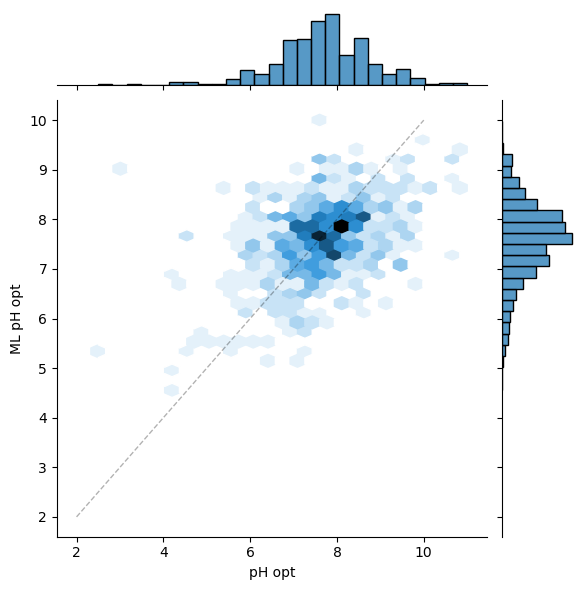

In [99]:
g = sns.jointplot(df_err, x="pH opt", y="ML pH opt", 
              # alpha=0.3, s=5, linewidth=0, 
                  kind="hex"
             )
g.ax_joint.plot([2,10], [2,10], ls='--', alpha=0.3, color="black", linewidth=1)

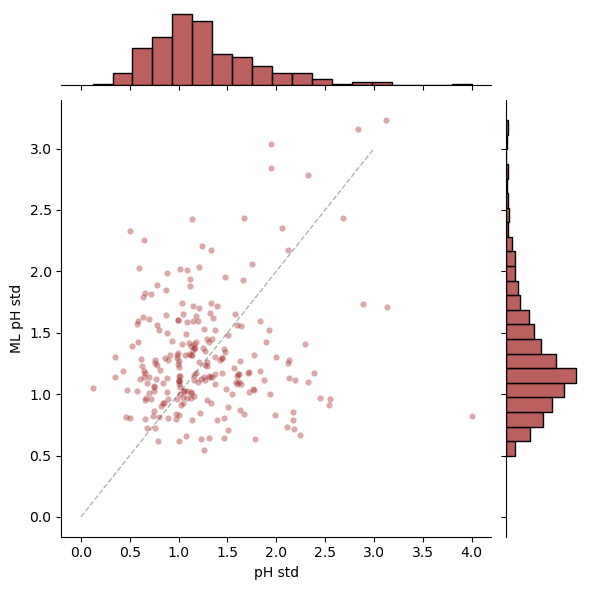

In [100]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              alpha=0.4, s=20, linewidth=0, 
                  # kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.3, color="black", linewidth=1)

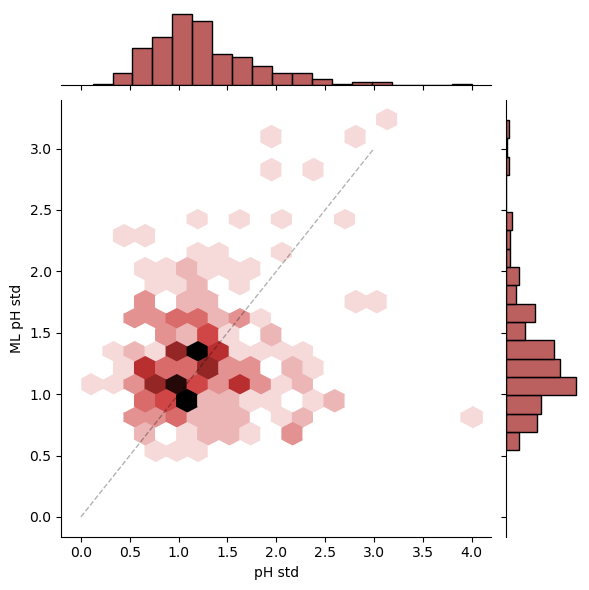

In [101]:
g = sns.jointplot(df_err, x="pH std", y="ML pH std", 
              # alpha=0.4, s=20, linewidth=0, 
                  kind="hex",
                  color="brown",
             )
g.ax_joint.plot([0,3], [0,3], ls='--', alpha=0.3, color="black", linewidth=1)

In [103]:
len(df_err)

558

In [104]:
df_err

,pH opt,pH std,ML pH opt,ML pH std
0,5.500000,NaN,7.573602,1.191083
1,7.250000,NaN,7.897350,0.819812
2,7.500000,NaN,7.879851,1.160311
3,7.600000,NaN,5.866752,0.703047
4,7.000000,NaN,7.990245,1.707971
...,...,...,...,...
553,7.905451,0.874271,7.785497,1.847724
554,7.771832,1.664941,6.857756,0.835491
555,8.841219,1.462182,7.070836,0.646042
556,7.062500,NaN,5.815723,1.102091


In [105]:
len(df_err.dropna())

236